预测单个时间步骤：
    单个特征。
    所有特征。
预测多个时间步骤：
    单次：一次做出所有预测。
    自回归：一次做出一个预测，并将输出馈送回模型。

In [ ]:
import csv
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
#----------------常用模块----------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#----------------核心模型----------------
from sklearn.linear_model import LinearRegression
#----------------忽略报警----------------
import warnings
warnings.filterwarnings('ignore')
#----------------lstm模块----------------
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

import tensorflow.keras
import tensorflow as tf
#----------------seq2seq模块----------------
import collections
import math
import tensorflow as tf
# from d2l import tensorflow as d2l

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
h_264_path = '/content/drive/MyDrive/data_H.264 and H.265 video traffic modeling using neural networks/h.264'
h_265_path = '/content/drive/MyDrive/data_H.264 and H.265 video traffic modeling using neural networks/h.265'

In [ ]:
def get264dataframe(filename="Tokyo Olympics G16B3-QP28.csv"):
  testcsv = pd.read_csv(os.path.join(h_264_path,filename),header=None)
  testcsv.rename(columns={0:'frame num',1:'frame arr time',2:'frame type',3:'frame size',4:'psnr-y',5:'psnr-u',6:'psnr-v'},inplace = True)
  testcsv_pre = testcsv.loc[:,['frame num', 'frame type', 'frame size']]
  type = {'I':1,'P':2,'B':3}
  testcsv_pre["frame type"] = testcsv_pre["frame type"].map(type)
  return testcsv_pre

def get265dataframe(filename="Big Buck Bunny G24B7 QP10.csv"):
  testcsv = pd.read_csv(os.path.join(h_265_path,filename),header=None)
  testcsv.rename(columns={0:'frame num',1:'frame arr time',2:'frame type',3:'frame size',4:'psnr-y',5:'psnr-u',6:'psnr-v'},inplace = True)
  testcsv_pre = testcsv.loc[:,['frame num', 'frame type', 'frame size']]
  type = {'I':1,'P':2,'B':3}
  testcsv_pre["frame type"] = testcsv_pre["frame type"].map(type)
  return testcsv_pre


In [ ]:

NBC38 = get264dataframe('NBC news G16B3-QP38.csv')
SOL38 = get264dataframe('Silence of the lambs G16B3-QP38.csv')
SW38 = get264dataframe('Star Wars G16B3-QP38.csv')
TOL38 = get264dataframe('Tokyo Olympics G16B3-QP38.csv')
#
#
BP25 = get265dataframe('Blue Planet G24B7 QP25.csv')
ED25 = get265dataframe('Elephants Dream G24B7 QP25.csv')


# display data

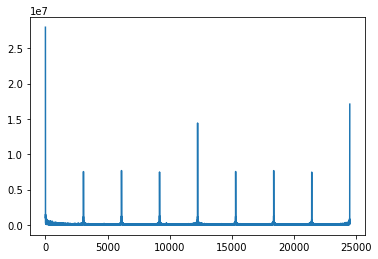

In [ ]:
df = NBC38
fft = tf.signal.rfft(df['frame size'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df['frame size'])
# hours_per_year = 30
# years_per_dataset = n_samples_h/(hours_per_year)
#
# f_per_year = f_per_dataset/years_per_dataset
# plt.step(f_per_year, np.abs(fft))
# plt.xscale('log')
#
# plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
# _ = plt.xlabel('Frequency (log scale)')

plt.plot(np.abs(fft))

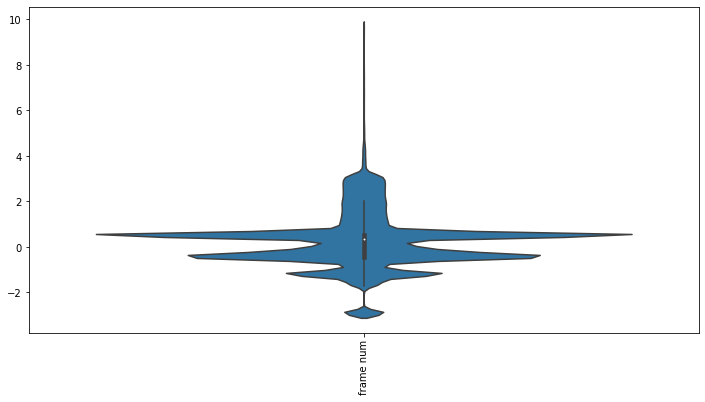

In [ ]:
# 数据拆分
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# 归一化
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# make dataset

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
      return inputs, labels


  def plot(self, model=None, plot_col='frame size', max_subplots=3):
      inputs, labels = self.example
      plt.figure()  #  figsize=(12, 8)
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('frame size')



  def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)

      return ds


@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# 多步预测  单次


Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label indices: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): None

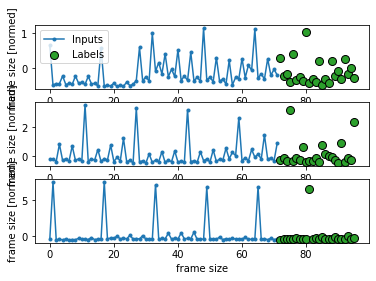

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=72,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# baseline 平移

304/304 [==============================] - 2s 6ms/step - loss: 1.1770 - mean_absolute_error: 0.5140


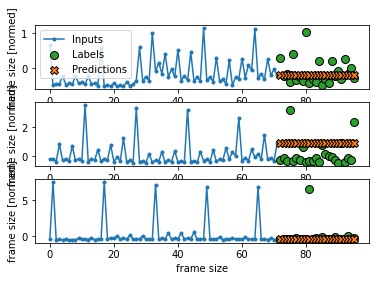

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Epoch 1/20
1069/1069 [==============================] - 9s 8ms/step - loss: 1.6329 - mean_absolute_error: 0.8613 - val_loss: 1.8566 - val_mean_absolute_error: 0.9623
Epoch 2/20
1069/1069 [==============================] - 5s 4ms/step - loss: 0.7484 - mean_absolute_error: 0.5414 - val_loss: 0.7684 - val_mean_absolute_error: 0.5806
Epoch 3/20
1069/1069 [==============================] - 5s 5ms/step - loss: 0.5883 - mean_absolute_error: 0.4344 - val_loss: 0.5638 - val_mean_absolute_error: 0.4498
Epoch 4/20
1069/1069 [==============================] - 5s 5ms/step - loss: 0.5522 - mean_absolute_error: 0.3937 - val_loss: 0.5379 - val_mean_absolute_error: 0.4114
Epoch 5/20
1069/1069 [==============================] - 5s 5ms/step - loss: 0.5442 - mean_absolute_error: 0.3808 - val_loss: 0.5372 - val_mean_absolute_error: 0.4047
Epoch 6/20
1069/1069 [==============================] - 5s 5ms/step - loss: 0.5428 - mean_absolute_error: 0.3781 - val_loss: 0.5382 - val_mean_absolute_error: 0.4049
Epoc

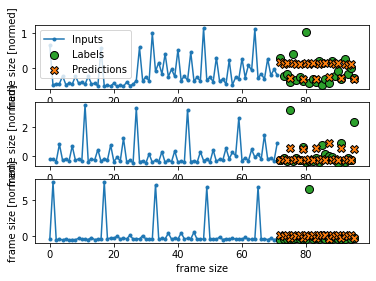

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.HeNormal()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

304/304 [==============================] - 1s 4ms/step - loss: 0.2101 - mean_absolute_error: 0.2081


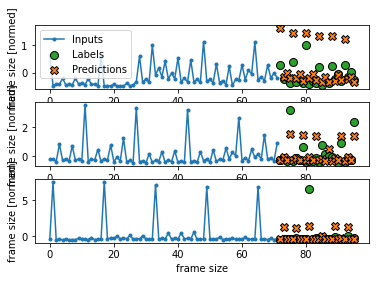

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

304/304 [==============================] - 3s 10ms/step - loss: 0.3770 - mean_absolute_error: 0.3779


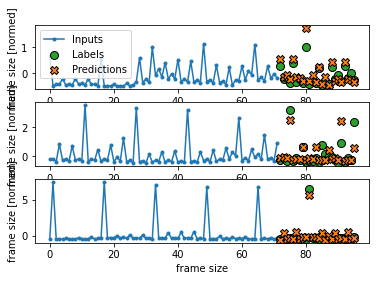

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
test_df.mean()

frame num     2.969201
frame type    0.000144
frame size   -0.034139
dtype: float64